In [4]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sci

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#files
import os

In [51]:
os.getcwd()
df = pd.read_csv('../Data/train.csv')
dt = pd.read_csv('../Data/test.csv')

In [3]:
df.head(3)

,Index,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
0,0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,0.000022,0.000044,0.002212,6.214737e-07,200.000000,-0.000196,1.533780
1,1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,0.000042,0.000042,0.010932,3.414868e-05,300.000000,-0.003798,0.843604
2,2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,0.000001,0.000002,0.000306,4.079460e-08,159.692076,-0.000003,29.824024


In [4]:
df.shape

(623817, 17)

In [15]:
c = df.columns
c

Index(['Index', 'Market', 'Day', 'Stock', 'x0', 'x1', 'x2', 'x3A', 'x3B',
       'x3C', 'x3D', 'x3E', 'x4', 'x5', 'x6', 'y', 'Weight'],
      dtype='object')

In [76]:
#get rid of NaN values
#find out which columns has null values
columns = df.columns
for i in range(len(df.columns)):
    index = df.index[df[columns[i]].isnull()]
    if index.shape[0]>0:
        print(df.columns[i],index.shape)
        df[columns[i]] = df[columns[i]].fillna(0)
columns2 = dt.columns
for i in range(len(dt.columns)):
    index2 = dt.index[dt[columns2[i]].isnull()]
    if index2.shape[0]>0:
        print(dt.columns[i],index2.shape)
        dt[columns2[i]] = dt[columns2[i]].fillna(0)

In [77]:
#training dataset and test dataset
x_train = df.drop(['Weight','y'],axis = 1)
x_weight = np.array(df.Weight)
y_train = df.y
x_test = dt

In [32]:
#regression modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [57]:
#KNN Regressor 25.6%
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
acc_knn = round(knn.score(x_train,y_train)*100,2)
acc_knn

25.6

In [56]:
#Random Forest 36.7%
rf = RandomForestRegressor()
rf.fit(x_train,y_train,sample_weight = x_weight)
acc_rf = round(rf.score(x_train,y_train,x_weight)*100,2)
acc_rf

34.48

In [224]:

#using random forest regressor, very low, around 10%
# kfold returns array indexes
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def run_kfold(model):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(x_train):
        fold += 1
        xfold_train, xfold_test = x_train.values[train_index], x_train.values[test_index]
        yfold_train, yfold_test = y_train.values[train_index], y_train.values[test_index]
        xfold_weight = x_weight[train_index]
        model.fit(xfold_train, yfold_train)
        #predictions = model.predict(xfold_test)
        accuracy = model.score(xfold_test, yfold_test)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(rf)

Fold 1 accuracy: 0.08160542313407126
Fold 2 accuracy: -0.04748002210001068
Fold 3 accuracy: -0.017682503865019905
Fold 4 accuracy: 0.009632548771566274
Fold 5 accuracy: 0.0150056421368846
Fold 6 accuracy: 0.12184604840497038
Fold 7 accuracy: 0.14461839290483514
Fold 8 accuracy: 0.11090489483175149


KeyboardInterrupt: 

In [66]:
# gridsearchCV
# what parameters are there for random forest regressor?
# best fit parameter: max_depth = 6, min_weight_fraction_leaf = 0.001,
# n_estimators = 40, min_sample_split = 4
from sklearn.model_selection import GridSearchCV
def RFTuneParameter(x_train, y_train, weight):
    rf = RandomForestRegressor(max_depth = 6, min_weight_fraction_leaf = 0.001)
    param_grid = { 
            "min_samples_split"        : [3, 4],
            "n_estimators"             : [30, 40]     
            }
    rfcv = GridSearchCV(rf,param_grid)
    if type(weight)==str:
        rfcv.fit(x_train,y_train)
    else:
        rfcv.fit(x_train,y_train,weight)
    return rfcv.best_score_, rfcv.best_params_
RFTuneParameter(x_train,y_train,x_weight)

(0.1222598308639286, {'min_samples_split': 4, 'n_estimators': 40})

In [78]:
# predict with best fit parameters
rf = RandomForestRegressor(max_depth = 6, min_weight_fraction_leaf = 0.001, n_estimators = 40, min_samples_split = 4)
rf.fit(x_train, y_train, x_weight)
yp = pd.Series(rf.predict(x_test)).rename('y')
yp.index.name = 'Index'
yp.head()

Index
0    0.000008
1    0.000008
2    0.000008
3    0.000008
4    0.000008
Name: y, dtype: float64

In [81]:
yp.to_csv('RandomForestRegressor_model.csv', header=True)

([<matplotlib.axis.XTick at 0x1a168b8160>,
 <a list of 15 Text xticklabel objects>)

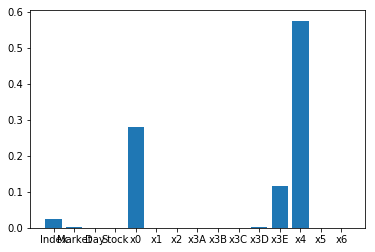

In [80]:
#get feature importance from random forest regression
importance = rf.feature_importances_
plt.bar(range(x_train.shape[1]),importance)
plt.xticks(range(x_train.shape[1]),x_train.columns)

In [83]:
#xgboost
import xgboost as xgb

In [84]:
dtrain = xgb.DMatrix(df)
dtest = xgb.DMatrix(dt)
# specify parameters via map
param = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'binary:logistic', 'silent': True,
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5}
num_round = 50
bst = xgb.train(param, dtrain, num_round)
# make prediction
# ntree_limit must not be 0
preds = bst.predict(dtest, ntree_limit=num_round)

XGBoostError: b'[21:52:52] src/objective/regression_obj.cc:43: Check failed: info.labels.size() != 0U (0 vs. 0) label set cannot be empty\n\nStack trace returned 2 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000001a14a291c9 _ZN4dmlc15LogMessageFatalD1Ev + 41\n[bt] (1) 1   libstdc++.6.dylib                   0x0000001a14e30f80 _ZTVNSt7__cxx1115basic_stringbufIcSt11char_traitsIcESaIcEEE + 16\n'